In [145]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib import style
from collections import Counter
import re
from geotext import GeoText
from wordcloud import WordCloud
from PIL import Image
import math
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import string
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from fuzzywuzzy import process
import random
import pickle
from sklearn.cross_validation import train_test_split
style.use('fivethirtyeight')


In [2]:
# constants
DATA_PATH = '../data/'
JOBS_PATH = DATA_PATH + 'jobs/'
IMG_PATH = DATA_PATH + 'images/'

In [3]:
try:
    df = pd.read_pickle(JOBS_PATH + 'monster-jobs.pickle')
except FileNotFoundError:
    df = pd.read_csv(JOBS_PATH + 'monster-jobs.csv')
    df.to_pickle(JOBS_PATH + 'monster-jobs.pickle')

LENGTH = len(df)

In [4]:
descriptions = df['job_description']
job_titles = df['job_title']

In [134]:
stop_words = set(stopwords.words('english'))
# additional stop words found in dataset
additional_stop_words = set(['Job','OpportunityAffirmative','Opportunity', 'monster','Most', 'Date', 'Apex', 'monster.com','Monstercom', 'MONS_LOG_VARS', 'var', 'ejb_header', 'JobID', 'Of', ])
stop_words = stop_words.union(additional_stop_words)

In [127]:
'''
returns a counter object containing all locations mined from location column
'''
def get_location_counter(column):
    all_noun_tokens = []
    location_tokens = []
    
    for elm in column:
        # tokenize location as a sentence
        # needed because some elements contain alot of text
        sent = sent_tokenize(elm)
        for sent_tok in sent:
            # tokenize sentece
            words = word_tokenize(sent_tok)
            # tag words by part of speech
            tagged = nltk.pos_tag(words)
            nouns = []
            # collect all proper nouns
            for tup in tagged:
                if tup[1] == 'NNP':
                    nouns.append(tup[0])
            all_noun_tokens.append(nouns)
    
    for token in all_noun_tokens:
        tagged = nltk.pos_tag(token)
        # create named entity from all nouns
        namedEnt = nltk.ne_chunk(tagged, binary=True)
        for ent in namedEnt:
            if(hasattr(ent, 'label') and ent.label() == 'NE'):
                location_str = ' '.join(e[0] for e in ent)
                # find combined entities such as San Jose, Las Vegas, etc
                loc = GeoText(location_str)
                if(len(loc.cities) > 0):
                    location_tokens.append(location_str.title())
    return Counter(location_tokens)

'''
creates word cloud of locations mined from dataset
focuses on cities
'''
def make_US_word_cloud(locations):
    # https://lollyjane.com/wp-content/uploads/2014/05/free-united-states-silhouette.jpg
    us_img = np.array(Image.open('../data/images/us-stencil.png'))
    
    wc = WordCloud(background_color="white", max_words=2000, mask=us_img,
                  stopwords=stop_words)
    wc.generate_from_frequencies(locations)
    wc.to_file(IMG_PATH + 'location-word-cloud.png')
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [128]:
locations = df['location']
loc_counter = get_location_counter(locations)

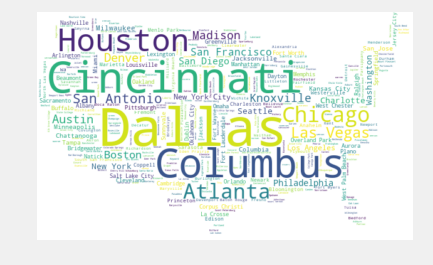

In [129]:
make_US_word_cloud(loc_counter)

In [130]:
# sector and organization column
# used for generating the industry of the job listing
organization = df['organization']
sector = df['sector']

In [141]:
'''
function to strip word of any location and punctuation and replaces punctuation with space 
'''
def strip_word_remove_location(word):
    # map punctuation to space
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    word = word.translate(translator)
    loc = GeoText(word)
    return word if len(loc.cities) == 0 and word != 'nan' else ''

'''
function serves multiple uses:
- to combine sector and organization column text into one column in order to find a representative industry 
- returns a Counter object of all tokenized words from the combined text
- returns a data frame containing the combined text
- returns a data frame containing the combined text and corresponding industry label based on basic fuzzy matching with input industry features list

'''
def combined_sector_org(sector, organization,stop_words, industry_features):
    all_tokens = []
    # industry specific stop words
    industry_stop_words = set(['All','Not', 'Services','Other','Entry','Level', 'Development', 'R', 'D', 'Non', 'Experienced'])
    # combined with global stop words
    stop_words = stop_words.union(industry_stop_words)
    
    # combined sector/organization text w/ label df
    sector_org_df = pd.DataFrame()
    # all combined sector/organization text 
    sector_org_df_all = pd.DataFrame()
    
    
    # iterate over entire dataset
    for i in range(len(df)):
        # strip sector and organization of current row
        stripped_sec = strip_word_remove_location(str(sector[i]))
        stripped_org =  strip_word_remove_location(str(organization[i]))
        # combine 
        combined_str = stripped_sec + ' ' + stripped_org

        # append to df
        combined_temp = pd.DataFrame([combined_str], columns=['combined'])
        sector_org_df_all = sector_org_df_all.append(combined_temp, ignore_index=True)
        
        # tokenize
        words = word_tokenize(combined_str)
       
        temp_tokens = []
        words_length = len(words)
        # only consider nonempty combined strings
        if(len(words) > 0):
            for word in words:
                # ensure concise data (data set contains alot of mislabelled data)
                if(words_length < 20):
                    if word not in stop_words:
                        # gather words
                        all_tokens.append(word.lower())
                        temp_tokens.append(word.lower())
            
            # generate industry label from words in combined sector/organization text 
            for token in temp_tokens:
                found, label = generate_label(token, industry_features)
                # if fuzzy match has been found 
                if (found):
                    # append combined text and label to data frame
                    # creating small subset of data with a label that was generate through basic means
                    industry_w_label = pd.DataFrame([[combined_str, label]], columns=['industry_text', 'industry'])
                    sector_org_df = sector_org_df.append(industry_w_label,  ignore_index=True)
                    break
                                        
    return Counter(all_tokens), sector_org_df, sector_org_df_all
'''
function to do fuzzy matching between an input word and list of labels
basic means for classification 
'''
def generate_label(token, industry_features):
    # do fuzzy matching
    fuzzy_match = process.extract(token, industry_features, limit=1)
    # ensure valid match
    if(fuzzy_match[0][1] > 90):
        label = fuzzy_match[0][0]
        return True, label
    else:
        return False, ''

In [132]:
# basic set of industries generated from analyzing common words found in sector and organization columns
industry_features = set(['Executive', 'Sofware', 'Retail', 'Healthcare', 'Finance', 'Transportation', 'Construction', 'Engineering', 'Manufacturing'])

In [142]:
'''
sector_org_counter - Counter object of all words in combined sector/organization columns
sector_org_labelled_df - data frame containing succesfully labelled sector/organization columns
sector_org_all - data frame containing all combined sector/organization text 
'''
sector_org_counter,sector_org_labelled_df, sector_org_all = combined_sector_org(sector, organization,stop_words, industry_features)

In [147]:
# generate 'bag of words' with the most common words from the sector and organization columns
most_common_word_features = [tup[0] for tup in sector_org_counter.most_common(500)]

'''
encodes input text into a dictionary containing each most common word mapped to either True/False 
'''
def generate_encoded_industry_features(text):
    # tokenize text
    words = set([word.lower() for word in word_tokenize(text)])
    word_feature_dict = {}
    # iterate over most common words
    for word in most_common_word_features:
        word_feature_dict[word] = (word in words)
    return word_feature_dict

'''
generates dataset with encoded combined sector/organization text with respective label
'''
def generate_encoded_data_with_label():
    data  = []
    for _,row in combined_df.iterrows():
        data.append((generate_encoded_industry_features(row['industry_text']), row['industry']))
    return data


In [150]:
industry_data = generate_encoded_data_with_label()
# shuffle data
random.shuffle(industry_data)
# 60/40 train/test split
training_set = industry_data[:6000]
test_set = industry_data[6000:]

In [21]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB

MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))

MultinomialNB accuracy percent: 0.9669852302345786
BernoulliNB accuracy percent: 0.9889226759339704


# Improved initial labelling using k-means clustering

In [182]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

industry_stop_words = set(['p', 'hospitality','job', 'jobid', 'com','All','Not', 'Services','Other','Entry','Level', 'Development', 'R', 'D', 'non','Services' 'Experienced'])
#industry_stop_words = set([w.lower() for w in industry_stop_words])
stop_words = stop_words.union(industry_stop_words)

vectorizer = TfidfVectorizer(stop_words=stop_words)
X = vectorizer.fit_transform(combined_df['industry_text'])
#X = vectorizer.fit_transform(combined_df_all['combined'])

true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

def print_top_terms(model):
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(true_k):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind]),
        print

    print("\n")
print_top_terms(model)


Top terms per cluster:
Cluster 0:
 retail
 manufacturing
 manager
 food
 business
 sales
 insurance
 production
 accounting
 finance
Cluster 1:
 healthcare
 health
 medical
 manager
 food
 business
 engineering
 general
 servicesmedical
 nursinggeneral
Cluster 2:
 software
 computer
 general
 manager
 softwarecomputer
 hardwarecomputer
 banking
 customer
 care
 client
Cluster 3:
 agencies
 employment
 staffing
 advertising
 pr
 marketing
 product
 business
 retail
 sales




In [183]:

'''
save

save_classifier = open('kmeans-industry.pickle', 'wb')
pickle.dump(model, save_classifier)
save_classifier.close()

open

classifier_f = open("kmeans-industry.pickle", "rb")
classifier = pickle.load(classifier_f)
classifier_f.close()
print_top_terms(classifier)
'''
industry_labels = {0:'business', 1:'health', 2:'technology', 3:'food services'}
Y = vectorizer.transform([''])
prediction = model.predict(Y)
prediction = industry_labels[prediction[0]]
print(prediction)

technology


In [90]:
def generate_industry_label_using_kmeans_model(model,df,label_dict):
    data = []
    for _,row in df.iterrows():
        text = row['industry_text']
        Y = vectorizer.transform([text])
        prediction = model.predict(Y)
        prediction = label_dict[prediction[0]]
        data.append((text, prediction))
    return data
        

In [91]:
industry_labels = {0:'business', 1:'health', 2:'technology', 3:'food services'}
data = generate_industry_label_using_kmeans_model(model,combined_df,industry_labels)
random.shuffle(data)
#training_set = data[:7000]
#test_set = data[7000:]

10604


In [ ]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)
print("MultinomialNB accuracy percent:",nltk.classify.accuracy(MNB_classifier, test_set))


BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test_set))


In [103]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(row[0] for row in training_set)
simple_train_dtm = vect.transform(row[0] for row in training_set)


In [106]:
X_train, X_test, y_train, y_test = train_test_split([row[0] for row in data], [row[1] for row in data], random_state=1)
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)

X_test_dtm = vect.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_dtm, y_train)
y_pred_class = clf.predict(X_test_dtm)

from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.96303281780460204

In [115]:
clf.predict(vect.transform(['']))

array(['business'],
      dtype='<U13')

In [ ]:
def process_descriptions(descriptions):
    all_tokens=[]
    tokenized_descriptions = []
    for row in descriptions:
        words= word_tokenize(row)
        temp_tokens=[]
        for word in words:
            if (not word in stop_words):
                all_tokens.append(word)
                temp_tokens.append(word)
        tokenized_descriptions.append(temp_tokens)
    return Counter(all_tokens),tokenized_descriptions

In [205]:
def process_job_titles(job_titles):
    
    all_tokens = []    
    processed_job_title_df = pd.DataFrame()
    for row in job_titles:
        words = word_tokenize(row)
        temp_tokens = []
        for word in words:
            word = strip_word_remove_location(word)
            word = word.strip()

            if(not word in stop_words and len(word) > 0):
                all_tokens.append(word)
                temp_tokens.append(word)
                
        temp_token_df = pd.DataFrame([' '.join(temp_tokens)], columns=['job_title'])
        processed_job_title_df = processed_job_title_df.append(temp_token_df, ignore_index=True) 
    return Counter(all_tokens), processed_job_title_df
            

In [206]:
job_title_token_cnt, processed_job_title_df = process_job_titles(job_titles)

In [211]:
X = vectorizer.fit_transform(processed_job_title_df['job_title'])
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
print_top_terms(model)

Top terms per cluster:
Cluster 0:
 manager
 project
 restaurant
 assistant
 program
 general
 quality
 senior
 construction
 account
Cluster 1:
 font
 verdana
 important
 px
 visible
 overflow
 ejb
 color
 margin
 header
Cluster 2:
 camphill
 shift
 supervisor
 part
 time
 overnight
 full
 restaurant
 barista
 jose
Cluster 3:
 sales
 specialist
 assistant
 technician
 analyst
 associate
 time
 coordinator
 nurse
 senior
Cluster 4:
 engineer
 quality
 assurance
 software
 combat
 engineering
 specialist
 construction
 systems
 senior
Cluster 5:
 service
 representative
 sales
 customer
 field
 technician
 rep
 outside
 advertising
 marketing


